In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
#reading all the files
train=pd.read_csv("kaggle/input/fake-news/train.csv")
test=pd.read_csv("kaggle/input/fake-news/test.csv")
sub=pd.read_csv("kaggle/input/fake-news/submit.csv")

In [3]:
train.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
train.shape

(20800, 5)

In [5]:
train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
train=train.dropna()

In [7]:
train.reset_index(inplace=True) #resetting the index

In [14]:
!pip install seaborn

  Using cached seaborn-0.11.0-py3-none-any.whl (283 kB)


<AxesSubplot:xlabel='label', ylabel='count'>

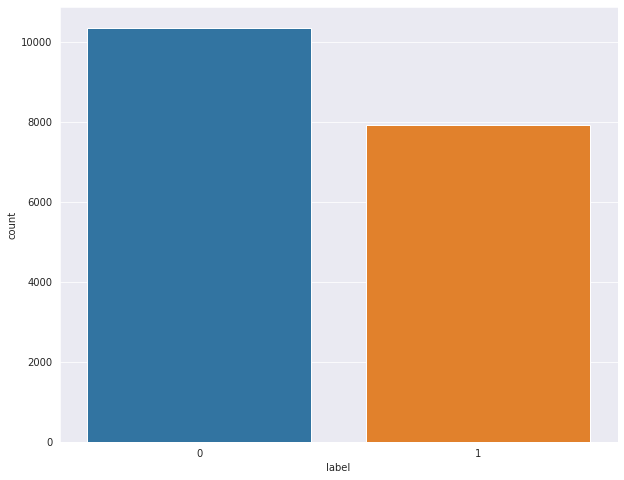

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(10,8))
sns.countplot(x='label',data=train)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional

In [17]:
x=train.drop('label',axis=1)
y=train.label
y.value_counts()

0    10361
1     7924
Name: label, dtype: int64

In [18]:
#vocab size 
vocab_size = 5000
 
#one hot representation

messages = x.copy()

messages.reset_index(inplace=True)

In [21]:
!pip install -U nltk

     |████████████████████████████████| 1.4 MB 594 kB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434677 sha256=617f8f097984652887a227bacd3a673d2f97bfa19dbde805c086dc5e8c64f2a5
  Stored in directory: /home/asus/.cache/pip/wheels/ff/d5/7b/f1fb4e1e1603b2f01c2424dd60fbcc50c12ef918bafc44b155
Successfully built nltk


In [22]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/asus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
#data set preprocessing 

from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()
corpus=[]
for i in range(0,len(messages)):
    result = re.sub('[^a-zA-Z]',' ',messages['title'][i])
    result = result.lower()
    result = result.split()
    result = [ps.stem(word) for word in result if not word in stopwords.words('english')]
    result = ' '.join(result)
    corpus.append(result)

In [24]:
#Convert it into one hot vectors

onehot_rep = [one_hot(words,vocab_size) for words in corpus]
onehot_rep

[[519, 2306, 2888, 987, 3345, 4907, 2980, 3670, 831, 892],
 [4148, 1616, 2514, 1865, 1780, 3166, 560],
 [2647, 3377, 2926, 1359],
 [3275, 3123, 1736, 2162, 3891, 4552],
 [2413, 1780, 2855, 475, 3280, 3842, 1780, 3120, 308, 1118],
 [4021,
  4136,
  83,
  3108,
  1567,
  1249,
  3294,
  3485,
  4347,
  555,
  1356,
  4160,
  2059,
  4617,
  560],
 [858, 3325, 1611, 3688, 1976, 2652, 2032, 4787, 1841, 855, 1016],
 [3571, 4114, 104, 4472, 2295, 6, 1249, 338, 1841, 855, 1016],
 [281, 3746, 1858, 3343, 3562, 2984, 2121, 2854, 1249, 1284],
 [1419, 461, 458, 3884, 1123, 3525, 832, 606],
 [4582, 3950, 3415, 4196, 1981, 2219, 2116, 4533, 3127, 2093, 4022],
 [2162, 2271, 3345, 2984, 1249, 2295],
 [782, 1119, 3365, 534, 1507, 3929, 2495, 3578, 1025],
 [1599, 2574, 1235, 2409, 4583, 38, 1029, 1841, 855, 1016],
 [613, 624, 4215, 1113, 3240, 1841, 855, 1016],
 [4356, 2174, 121, 2620, 2038, 1941, 1141, 1336, 2771, 2772],
 [919, 2315, 1616],
 [478, 3130, 2549, 1328, 1249, 2433, 1685, 560],
 [1049, 1288

In [25]:
#set a maximum length for sentences
smax_length=20
#embedded representation
embedd = pad_sequences(onehot_rep,padding='pre',maxlen=smax_length)

In [26]:
dims=40
bi_model=Sequential()
bi_model.add(Embedding(vocab_size,dims,input_length=smax_length))
bi_model.add(Bidirectional(LSTM(100))) #lstm with 100 neurons
bi_model.add(Dense(1,activation='sigmoid'))
bi_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(bi_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
len(embedd)

18285

In [28]:
y.shape

(18285,)

In [29]:
x_final = np.array(embedd)
y_final = np.array(y)
x_final.shape,y_final.shape

((18285, 20), (18285,))

In [30]:
x_final

array([[   0,    0,    0, ..., 3670,  831,  892],
       [   0,    0,    0, ..., 1780, 3166,  560],
       [   0,    0,    0, ..., 3377, 2926, 1359],
       ...,
       [   0,    0,    0, ..., 1841,  855, 1016],
       [   0,    0,    0, ..., 4073, 3982,   57],
       [   0,    0,    0, ..., 4108,  308, 4901]], dtype=int32)

In [31]:
y_final

array([1, 0, 1, ..., 0, 1, 1])

In [32]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_final,y_final,test_size=0.3)

In [33]:
bi_model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64)

Epoch 1/20
200/200 [==============================] - 16s 81ms/step - loss: 0.2919 - accuracy: 0.8637 - val_loss: 0.1899 - val_accuracy: 0.9196
Epoch 2/20
200/200 [==============================] - 15s 75ms/step - loss: 0.1347 - accuracy: 0.9490 - val_loss: 0.1974 - val_accuracy: 0.9191
Epoch 3/20
200/200 [==============================] - 16s 79ms/step - loss: 0.0950 - accuracy: 0.9680 - val_loss: 0.2619 - val_accuracy: 0.9196
Epoch 4/20
200/200 [==============================] - 15s 74ms/step - loss: 0.0723 - accuracy: 0.9755 - val_loss: 0.2543 - val_accuracy: 0.9187
Epoch 5/20
200/200 [==============================] - 15s 76ms/step - loss: 0.0510 - accuracy: 0.9830 - val_loss: 0.3044 - val_accuracy: 0.9162
Epoch 6/20
200/200 [==============================] - 16s 79ms/step - loss: 0.0287 - accuracy: 0.9917 - val_loss: 0.3739 - val_accuracy: 0.9151
Epoch 7/20
200/200 [==============================] - 15s 76ms/step - loss: 0.0173 - accuracy: 0.9945 - val_loss: 0.3885 - val_accuracy:

In [34]:
#create a model
from tensorflow.keras.layers import Dropout
dims=40
bi_model=Sequential()
bi_model.add(Embedding(vocab_size,dims,input_length=smax_length))
bi_model.add(Dropout(0.3))
bi_model.add(Bidirectional(LSTM(100))) #lstm with 100 neurons
bi_model.add(Dropout(0.3))
bi_model.add(Dense(1,activation='sigmoid'))
bi_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(bi_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               112800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
bi_model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64)

Epoch 1/20
200/200 [==============================] - 16s 82ms/step - loss: 0.3042 - accuracy: 0.8595 - val_loss: 0.1927 - val_accuracy: 0.9172
Epoch 2/20
200/200 [==============================] - 15s 77ms/step - loss: 0.1445 - accuracy: 0.9438 - val_loss: 0.1964 - val_accuracy: 0.9187
Epoch 3/20
200/200 [==============================] - 16s 78ms/step - loss: 0.1066 - accuracy: 0.9624 - val_loss: 0.2053 - val_accuracy: 0.9158
Epoch 4/20
200/200 [==============================] - 15s 76ms/step - loss: 0.0886 - accuracy: 0.9703 - val_loss: 0.2344 - val_accuracy: 0.9141
Epoch 5/20
200/200 [==============================] - 15s 76ms/step - loss: 0.0722 - accuracy: 0.9764 - val_loss: 0.2771 - val_accuracy: 0.9145
Epoch 6/20
200/200 [==============================] - 16s 79ms/step - loss: 0.0567 - accuracy: 0.9807 - val_loss: 0.2878 - val_accuracy: 0.9147
Epoch 7/20
200/200 [==============================] - 15s 77ms/step - loss: 0.0474 - accuracy: 0.9855 - val_loss: 0.2944 - val_accuracy:

In [26]:
y_pred = bi_model.predict_classes(x_test)

In [27]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
cm=confusion_matrix(y_pred,y_test)
print("accuracy score :",accuracy_score(y_pred,y_test))
print("classification report :",classification_report(y_pred,y_test))

accuracy score : 0.9074006562158221
classification report :               precision    recall  f1-score   support

           0       0.91      0.93      0.92      3117
           1       0.90      0.88      0.89      2369

    accuracy                           0.91      5486
   macro avg       0.91      0.90      0.91      5486
weighted avg       0.91      0.91      0.91      5486



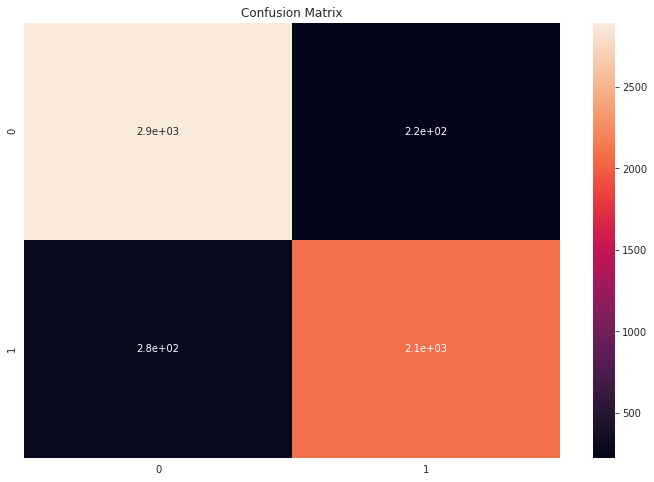

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,8))
sns.heatmap(cm,annot=True)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# saving best model to the disk

model_file = 'final_model.sav'
pickle.dump(linear_clf,open(model_file,'wb'))

In [ ]:
import pickle
var = input("Please enter the news text you want to verify: ")
    
# function to run for prediction
def detecting_fake_news(var):
    #retrieving the best model for prediction call
    load_model = pickle.load(open('final_model.sav', 'rb'))
    prediction = load_model.predict([var])
    if prediction[0]=='0':
        return (print("The given statement is FAKE"))
    elif prediction[0]=='1':
        return (print("The given statement is TRUE"))
        
                          
if __name__ == '__main__':
    detecting_fake_news(var)